In [1]:
import sys
sys.path.append("../../BayesFlow")
sys.path.append("../")

import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "torch"

import numpy as np
import pickle

import keras
import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
import bayesflow as bf
from dmc import DMC, dmc_helpers


with torch.enable_grad():
in contexts where you need gradients (e.g. custom training loops).


In [3]:
simulator = DMC(
    prior_means=np.array([16., 111., 0.5, 322., 75.]), 
    prior_sds=np.array([10., 47., 0.13, 40., 23.]),
    tmax=1500
)

In [4]:
approximator = keras.saving.load_model("../data/training_checkpoints/optuna_run1.keras")



/home/administrator/miniforge3/envs/bf_new/lib/python3.11/site-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


In [5]:
import pandas as pd

narrow_data = pd.read_csv('../data/model_data/experiment_data_narrow.csv')
wide_data = pd.read_csv('../data/model_data/experiment_data_wide.csv')

empirical_data = pd.concat([narrow_data, wide_data])

In [6]:
samples_narrow=dmc_helpers.fit_empirical_data(narrow_data, approximator)

samples_narrow["spacing"]="narrow"

samples_wide=dmc_helpers.fit_empirical_data(wide_data, approximator)

samples_wide["spacing"]="wide"

samples_complete=pd.concat((samples_wide, samples_narrow))

In [7]:
parts=samples_complete["participant"].unique()

samples_complete

A         tau      mu_c          t0          b  participant  \
0     7.331204  147.982452  0.537573  285.794220  72.104935         1108   
1     6.766285  137.817795  0.497661  286.070953  68.431778         1108   
2     4.778117   93.539398  0.585197  280.882202  80.001823         1108   
3     6.991055  106.325432  0.505781  285.747437  68.500206         1108   
4     7.187474  120.360565  0.583050  284.211731  74.584290         1108   
..         ...         ...       ...         ...        ...          ...   
995  23.912598  161.425720  0.627661  314.527039  82.973106       337788   
996   9.072463  119.341743  0.627010  312.705475  89.815598       337788   
997  23.138300  146.385284  0.650258  313.293274  91.921555       337788   
998  13.318760  130.199585  0.654160  312.197876  89.350510       337788   
999  16.311447  112.312004  0.614876  311.018738  87.447784       337788   

     sampling_time spacing  
0         0.053088    wide  
1         0.053088    wide  
2         0.053088    wide  
3         0.053088    wide  
4         0.053088    wide  
..             ...     ...  
995       0.047328  narrow  
996       0.047328  narrow  
997       0.047328  narrow  
998       0.047328  narrow  
999       0.047328  narrow  

[134000 rows x 8 columns]

## Posterior Predictive Check

In [8]:
def resim_data(post_sample_data, num_obs, num_resims = 50, param_names = ["A", "tau", "mu_c", "t0", "b"]):
    
    # generate random indices for random draws of posterior samples for resimulation
    random_idx = np.random.choice(np.arange(0,num_resims), size = num_resims)

    # select posterior samples
    resim_samples = post_sample_data.iloc[random_idx][param_names]

    # adjust number of trials in simulator (should be equal to the number of trials in the empirical data)
    simulator.num_obs=num_obs

    list_resim_dfs = []

    # resimulate
    for i in range(num_resims):
        resim =  simulator.experiment(A=resim_samples["A"].values[i],
                                tau=resim_samples["tau"].values[i],
                                mu_c=resim_samples["mu_c"].values[i],
                                mu_r=resim_samples["t0"].values[i],
                                b=resim_samples["b"].values[i])
        
        resim_df = pd.DataFrame(resim)
        
        resim_df["num_resim"] = i
        resim_df["partricipant"] = part
        
        list_resim_dfs.append(pd.DataFrame(resim_df))

    resim_complete = pd.concat(list_resim_dfs)
    
    return resim_complete

In [9]:
empirical_accuracies_congruent = []
empirical_accuracies_incongruent = []

resimulated_accuracies_congruent = []
resimulated_accuracies_incongruent = []


/tmp/ipykernel_35825/2663738492.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1,2, figsize=(10,3))


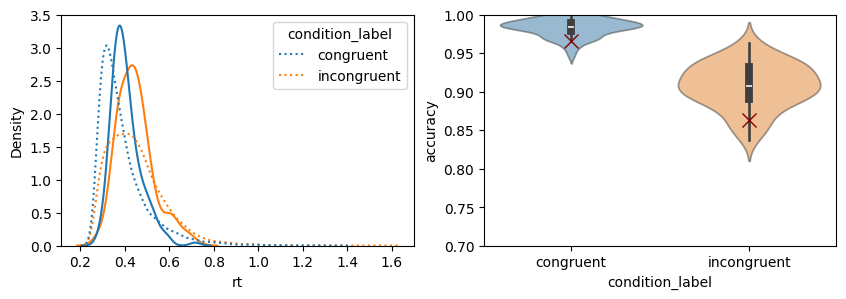

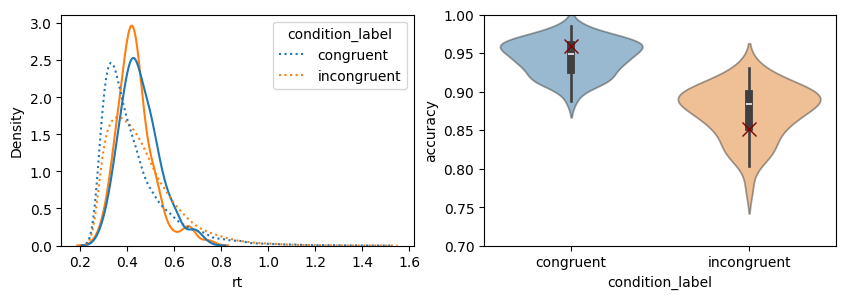

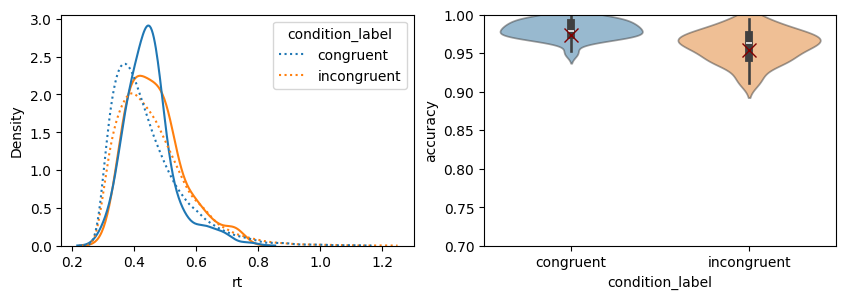

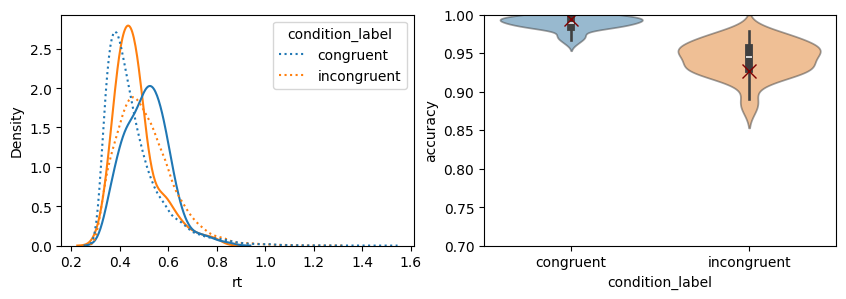

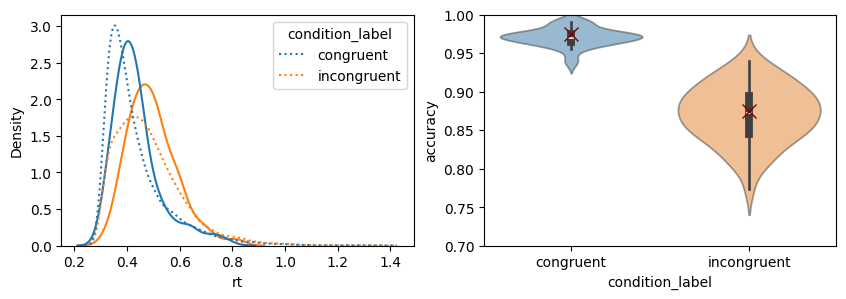

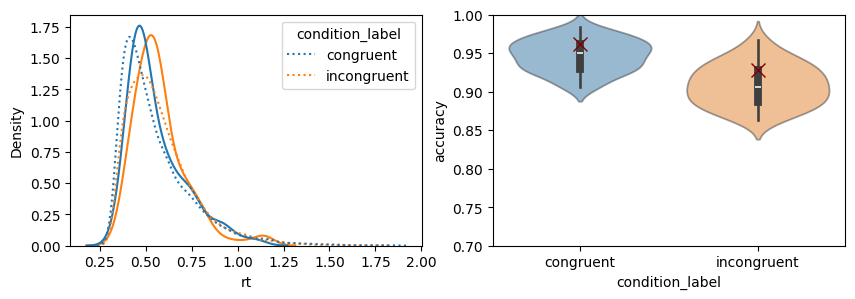

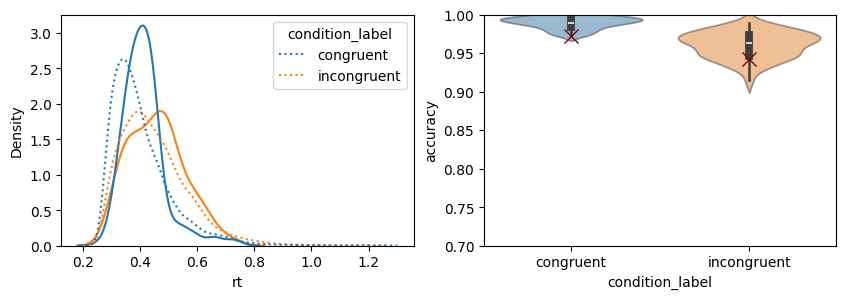

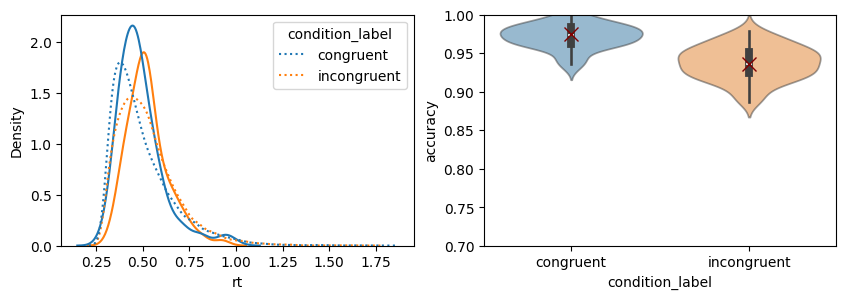

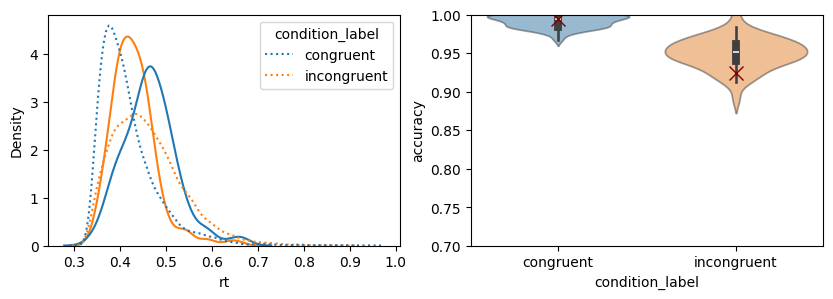

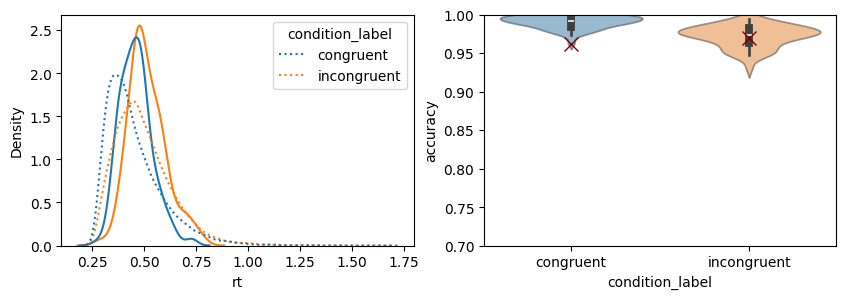

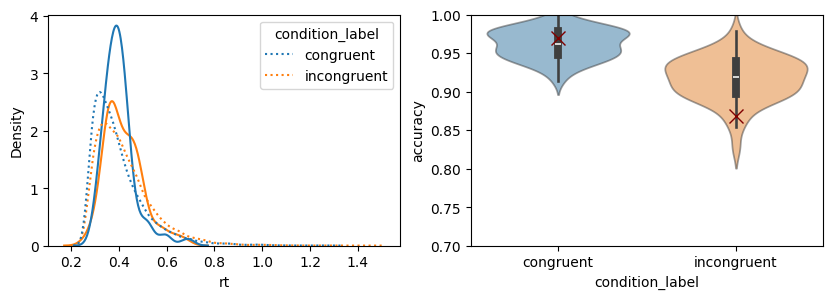

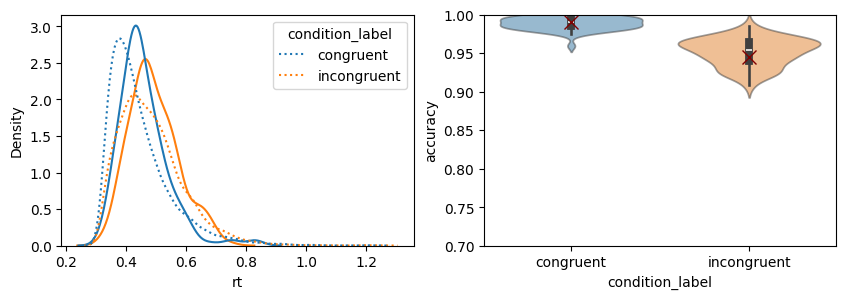

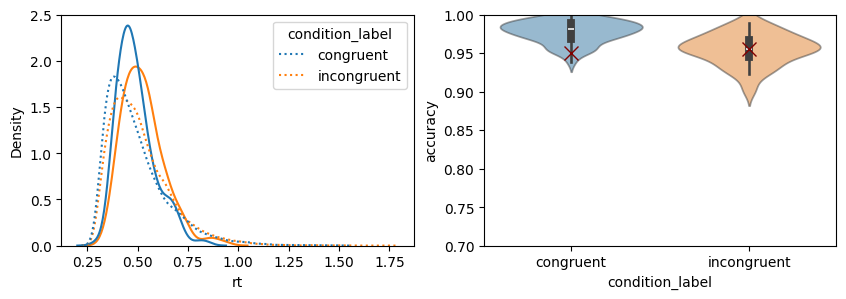

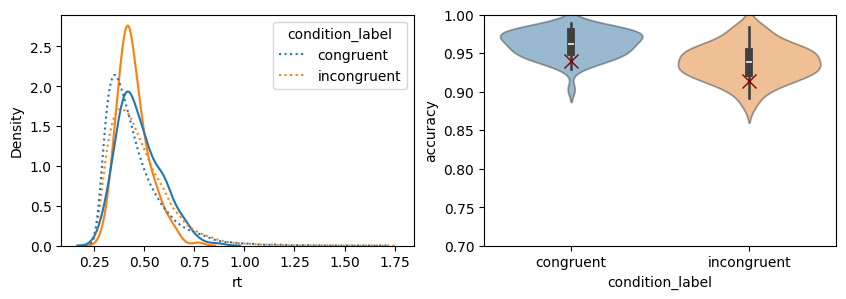

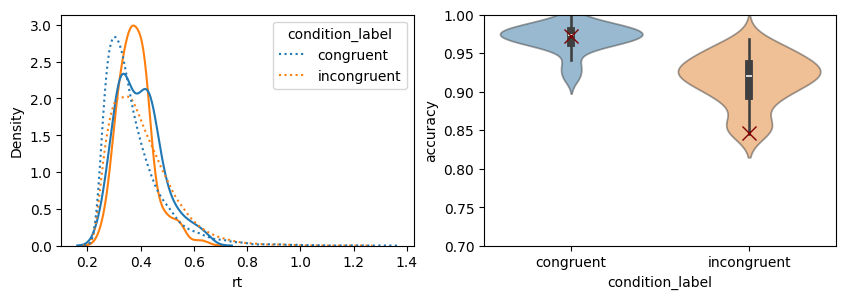

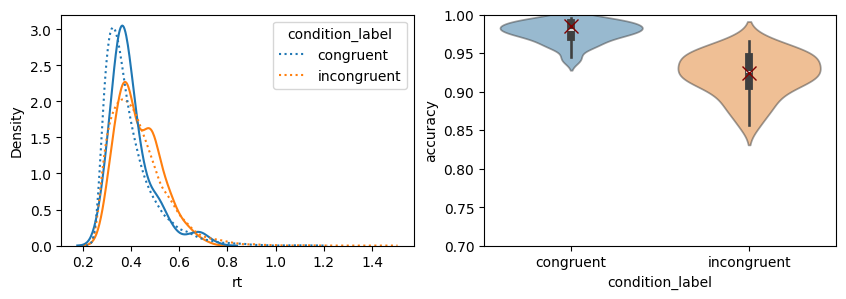

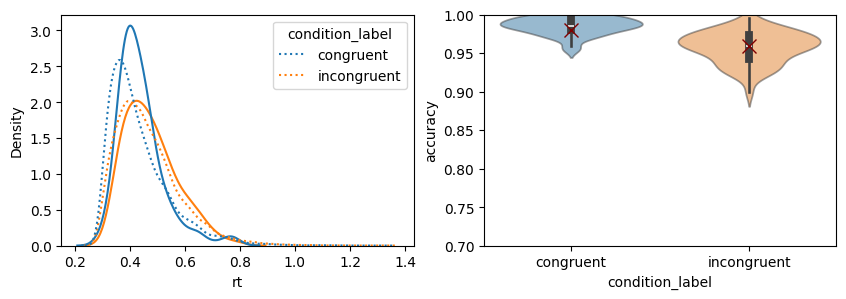

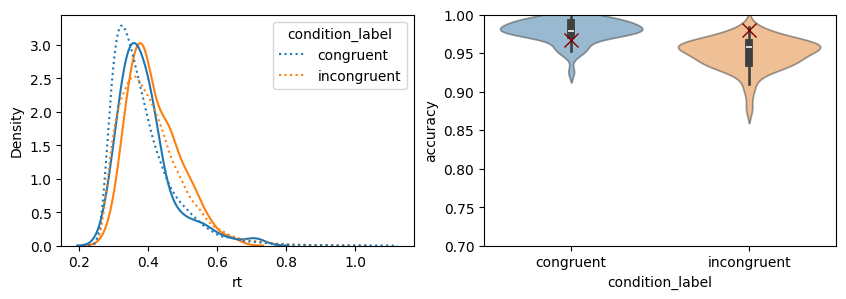

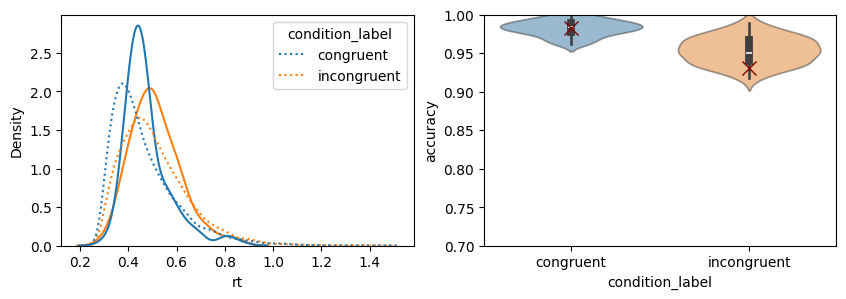

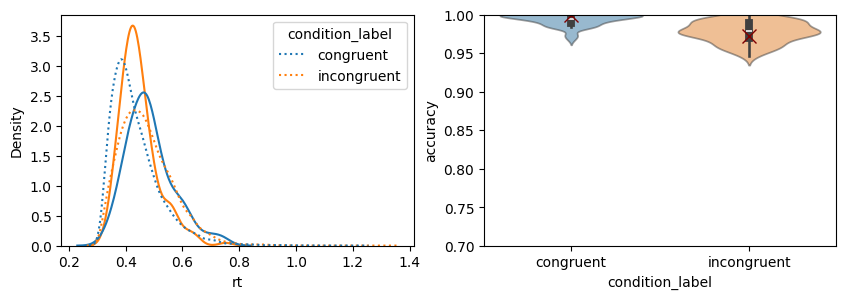

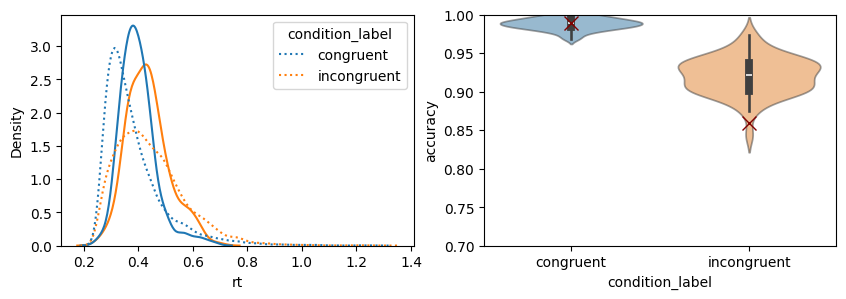

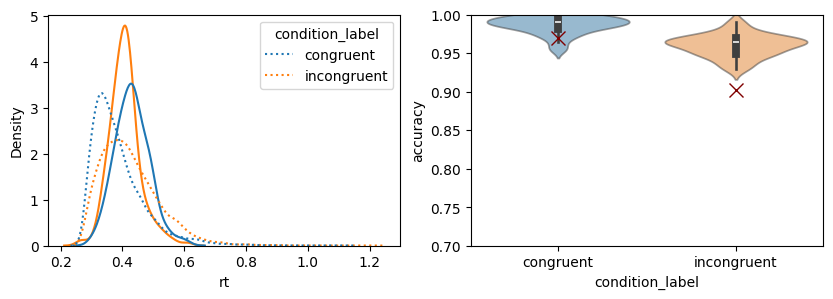

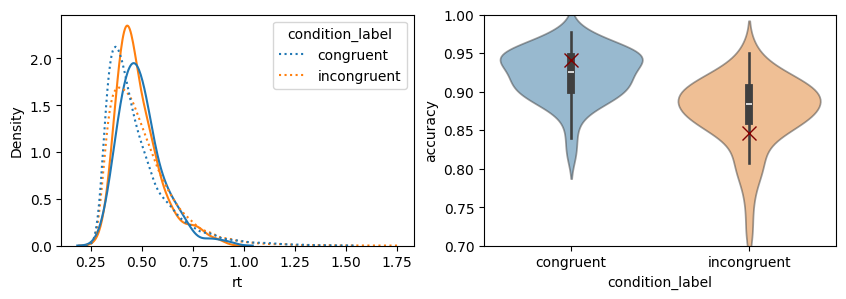

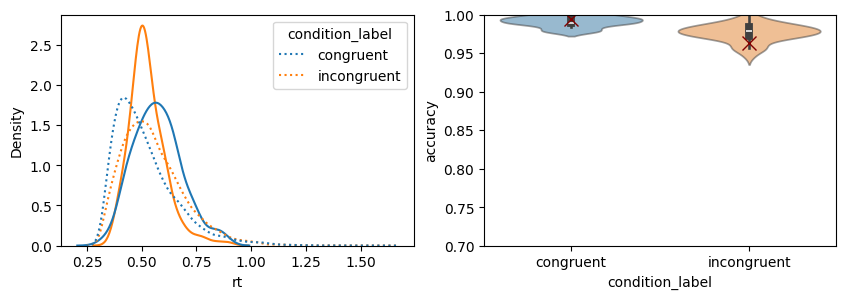

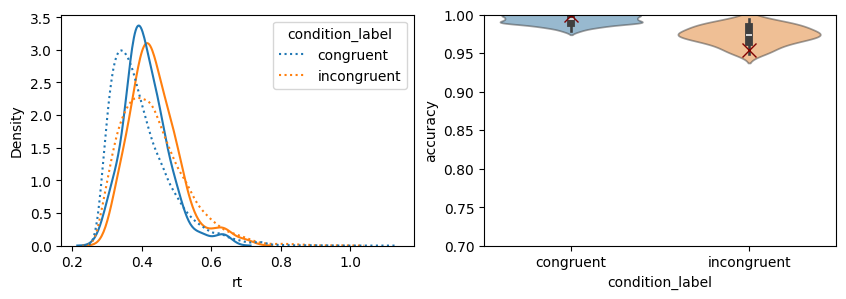

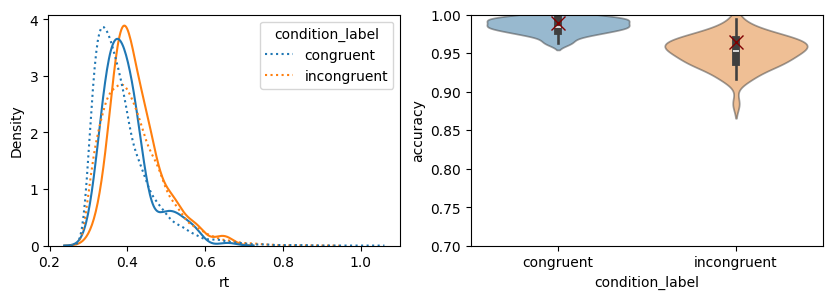

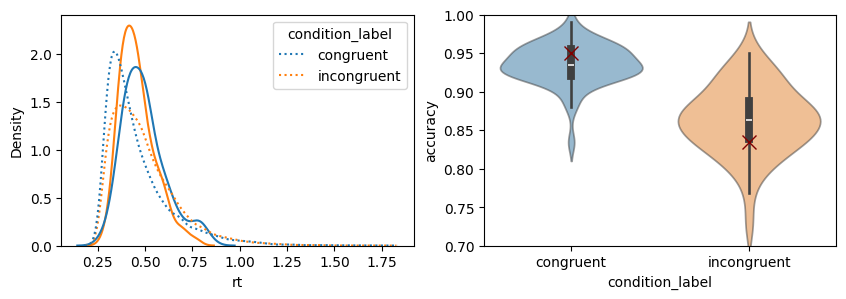

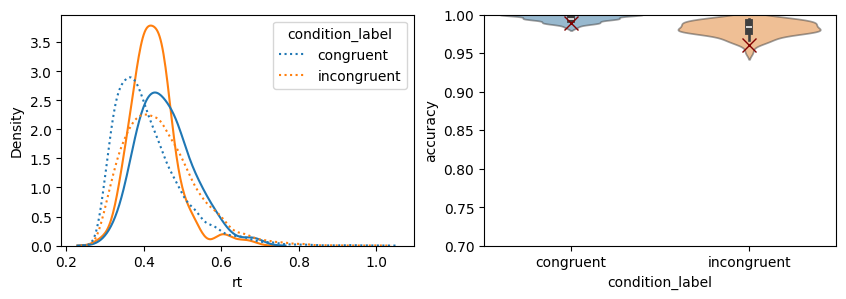

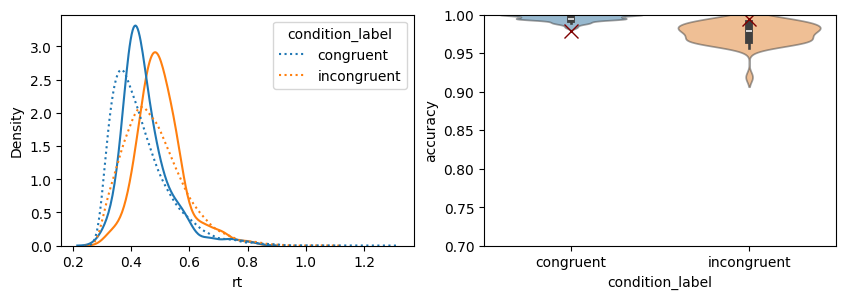

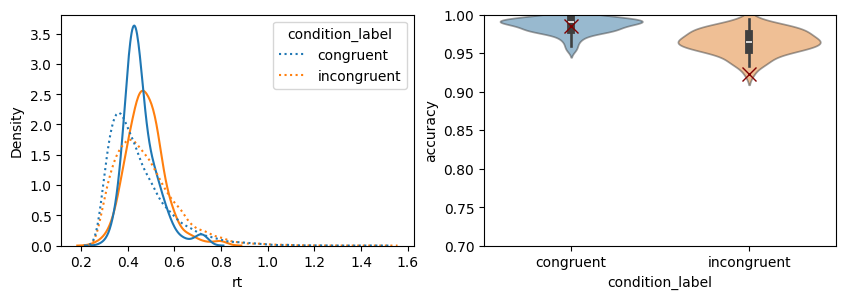

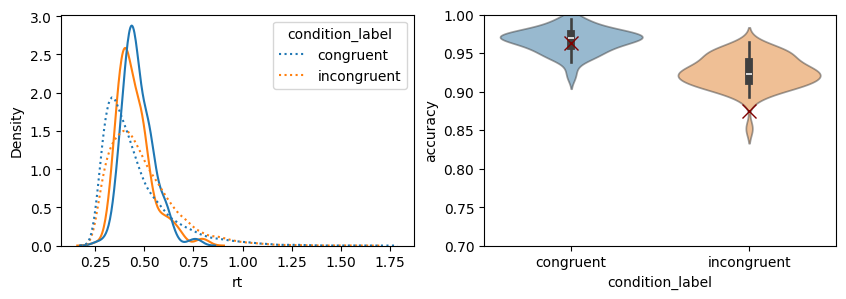

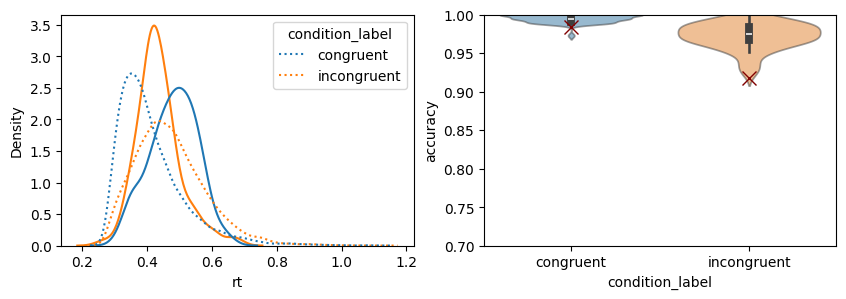

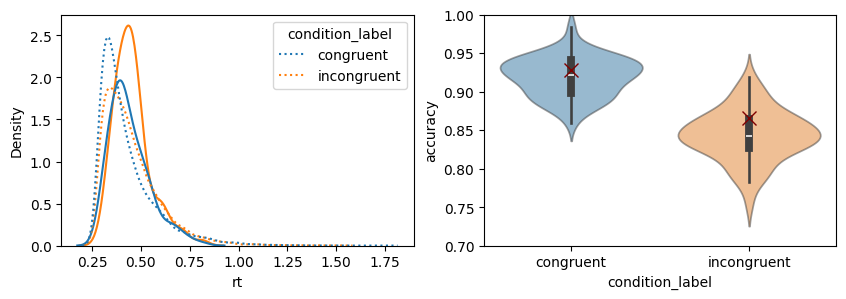

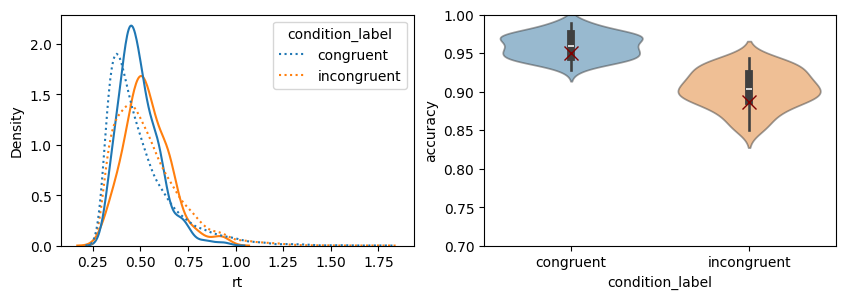

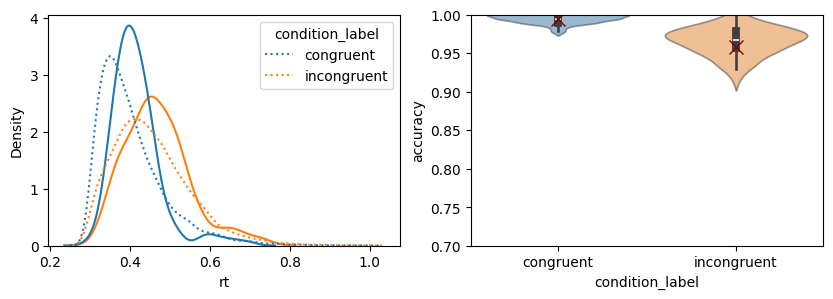

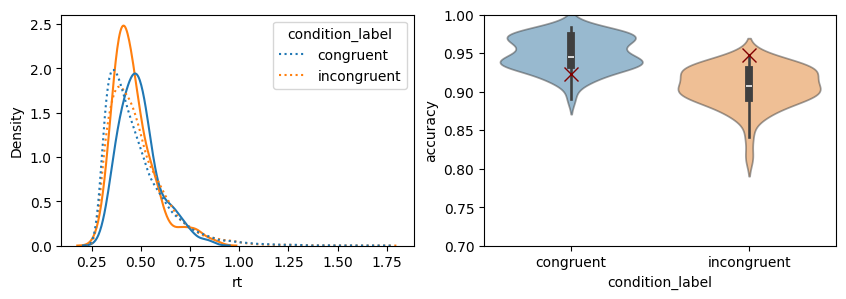

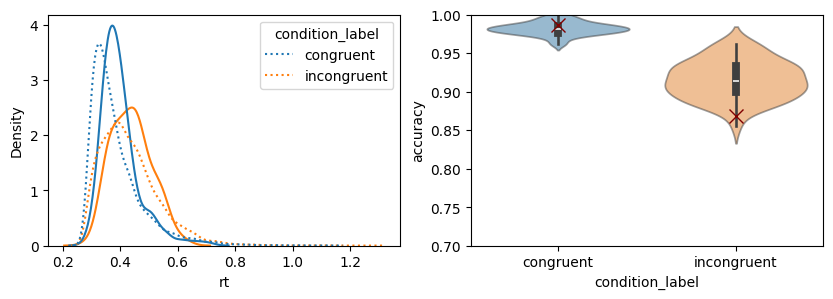

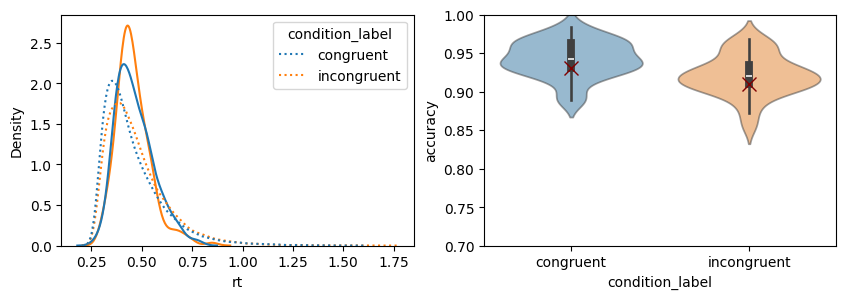

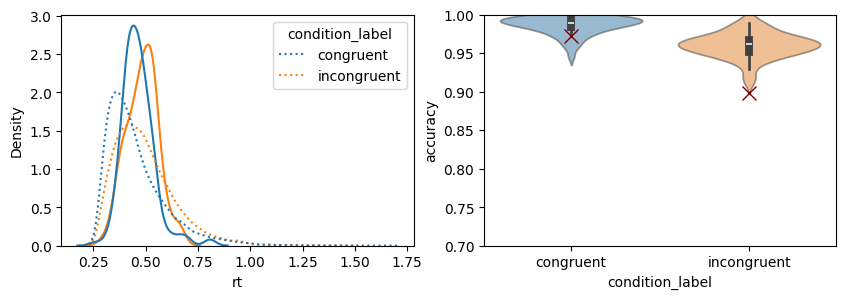

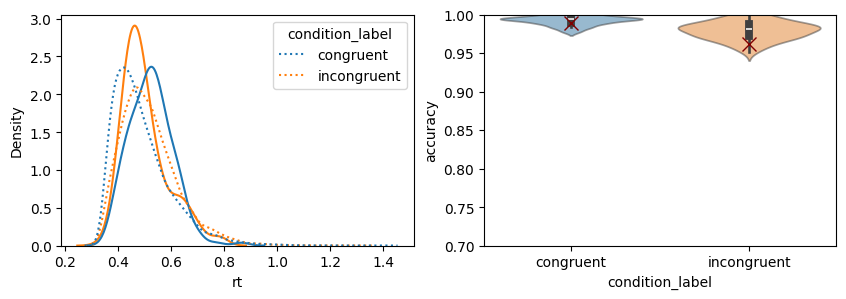

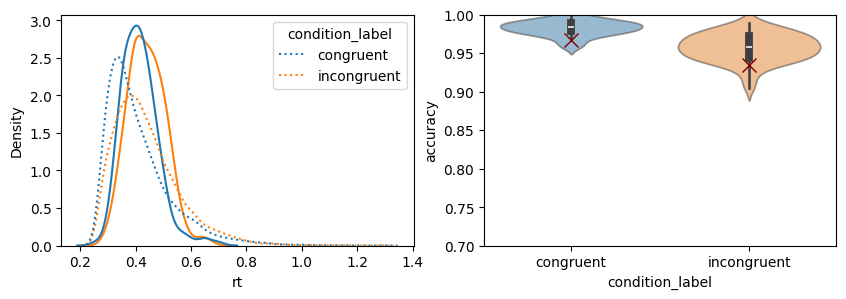

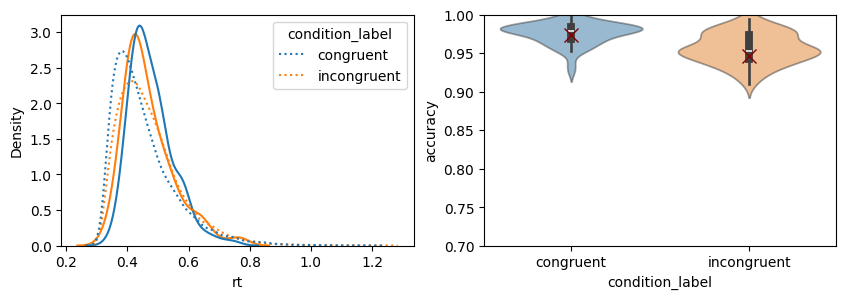

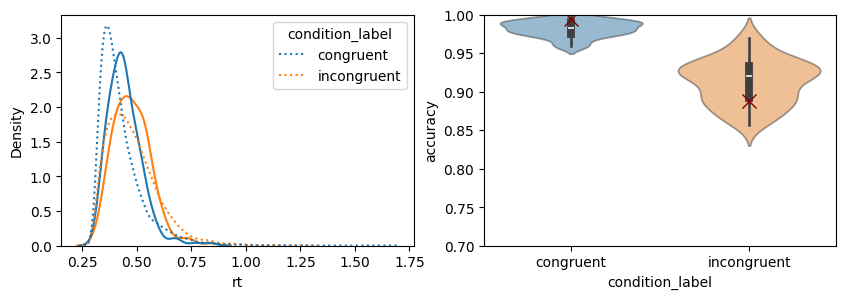

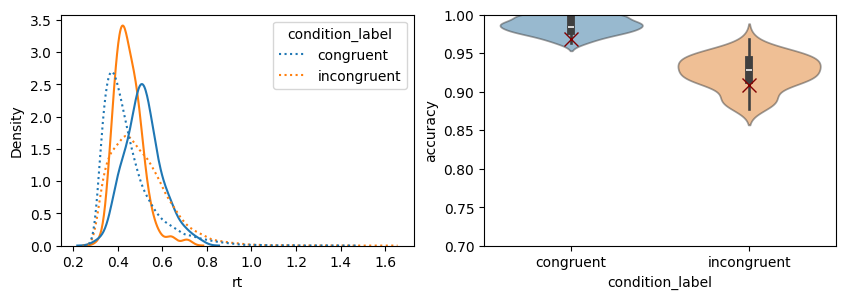

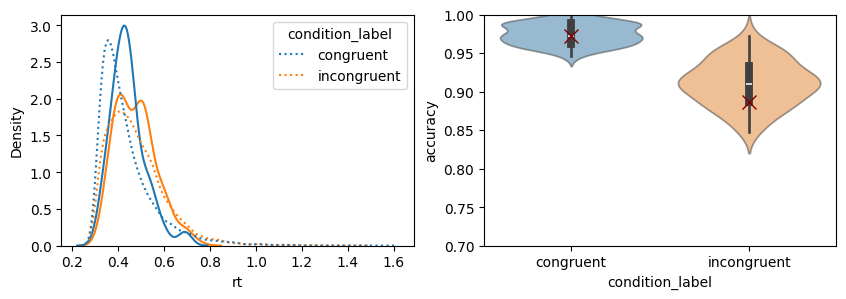

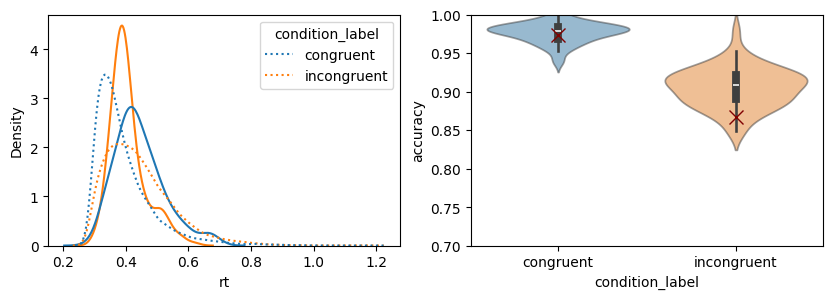

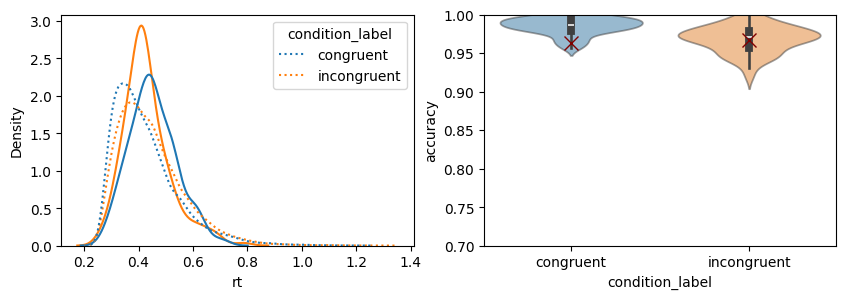

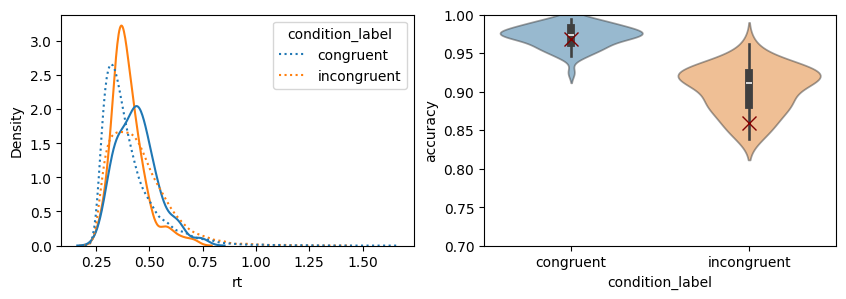

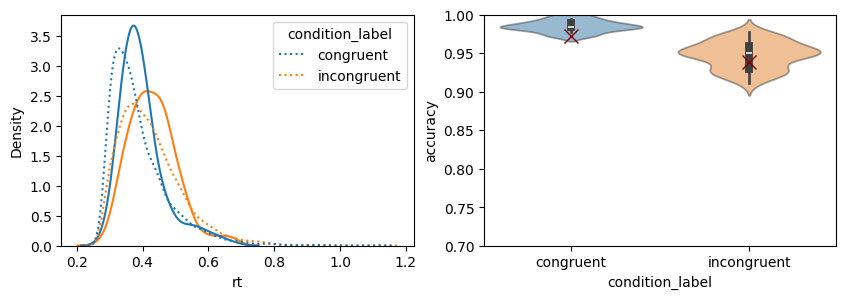

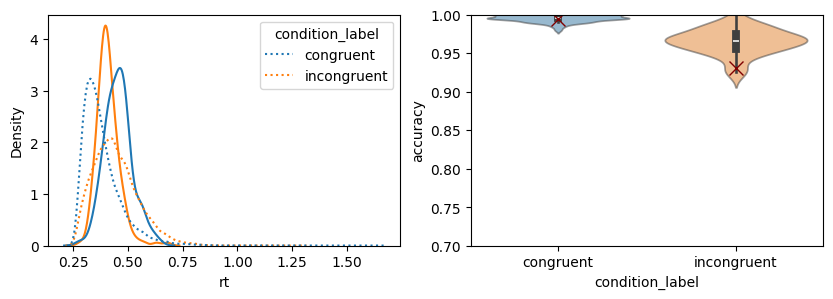

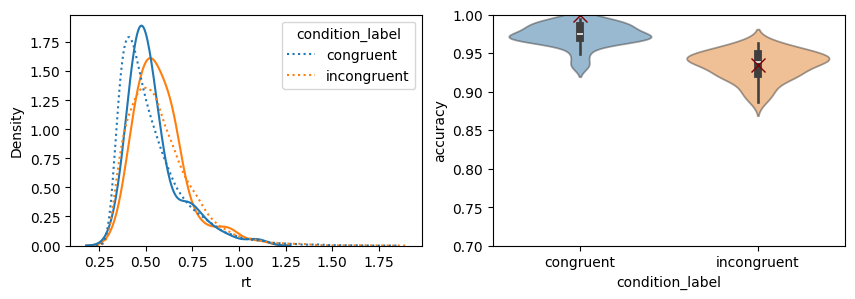

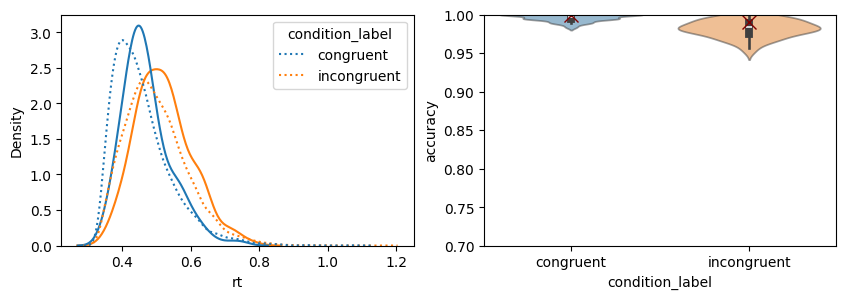

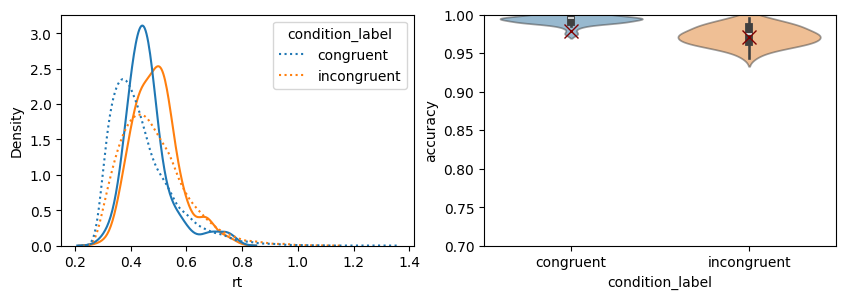

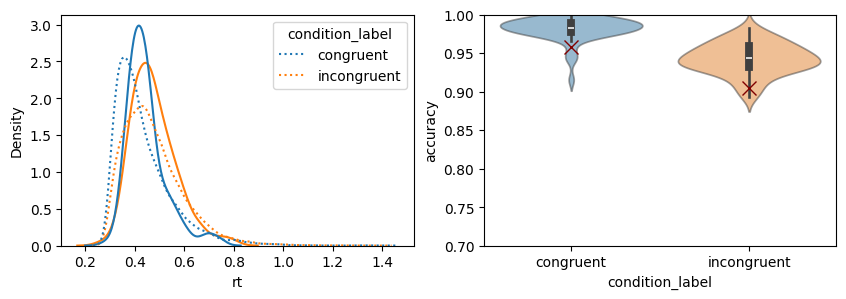

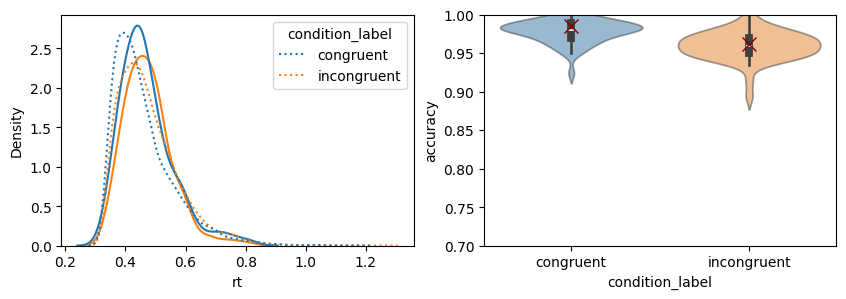

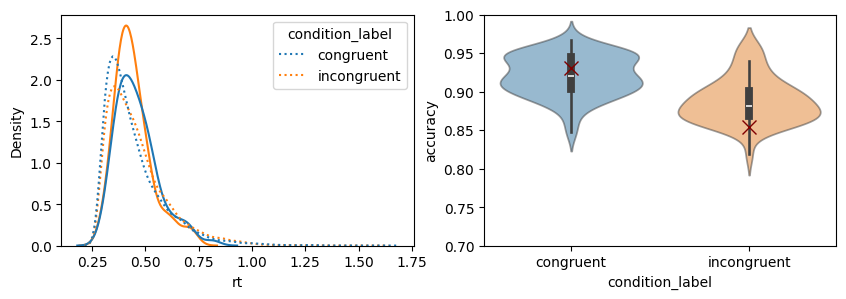

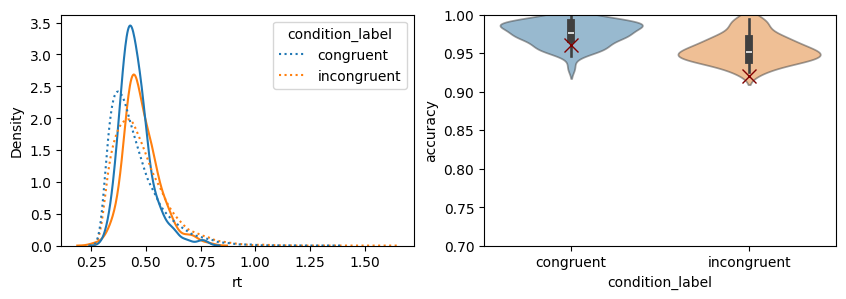

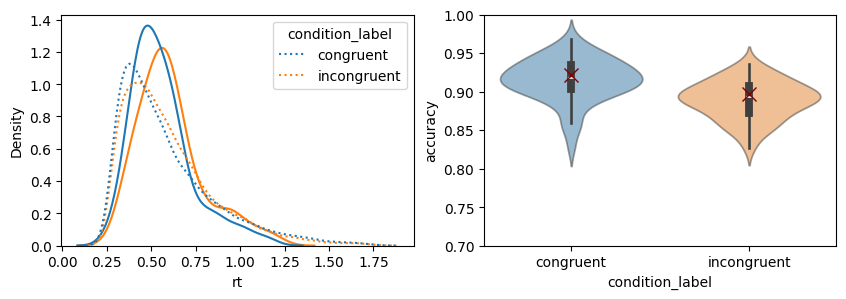

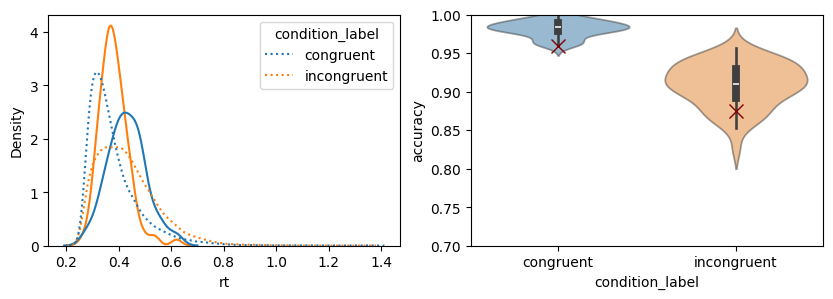

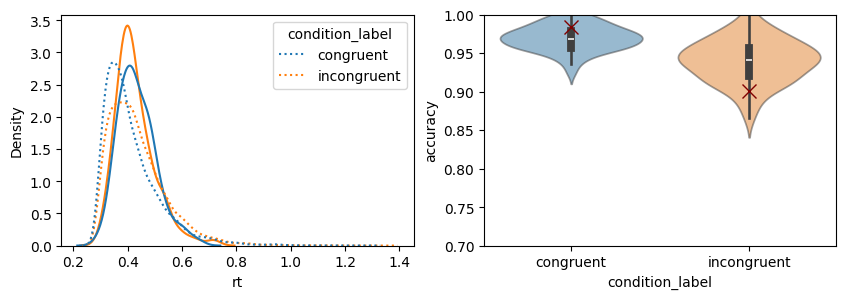

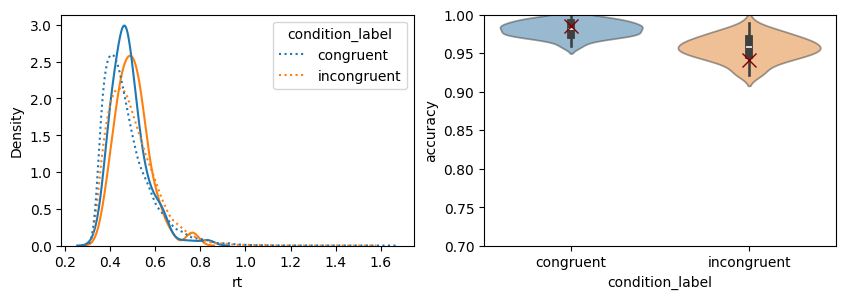

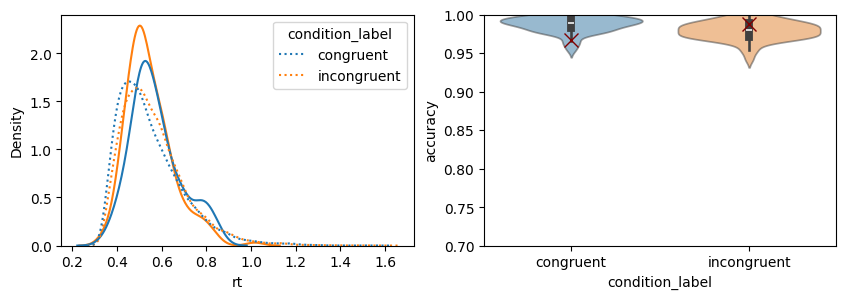

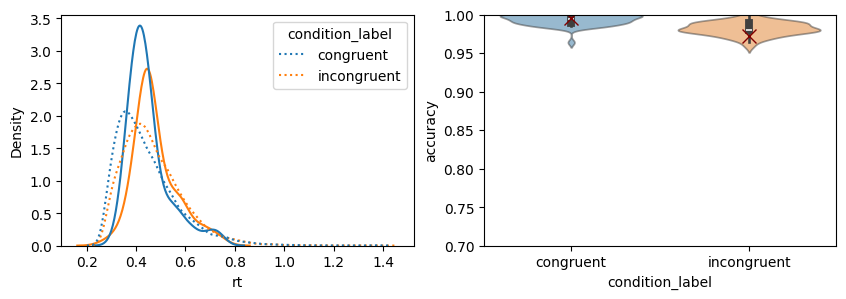

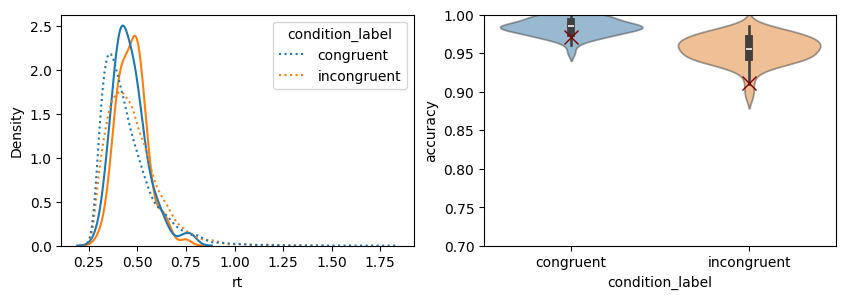

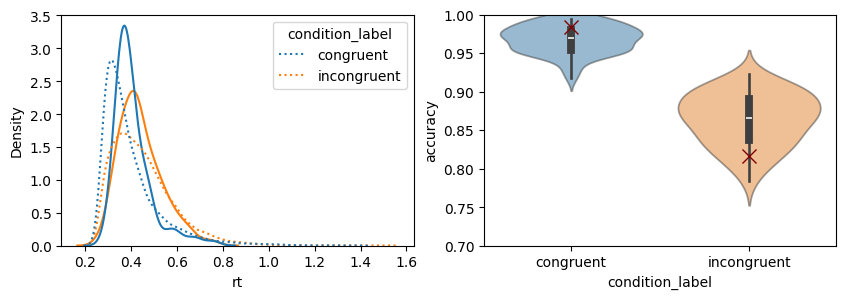

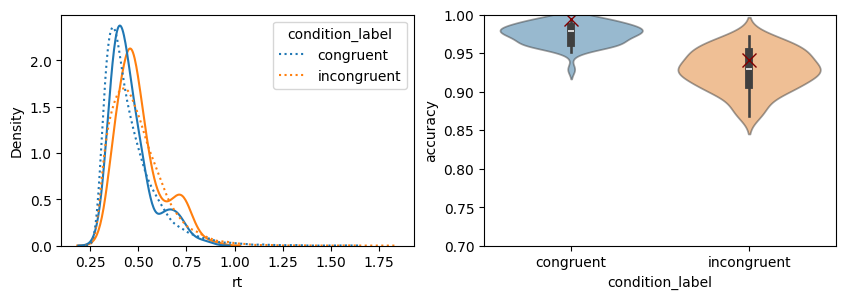

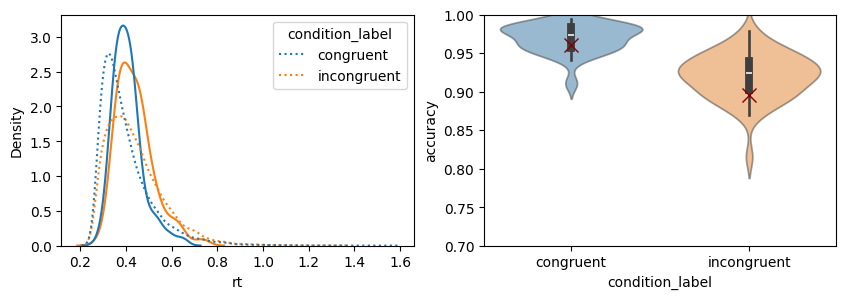

In [10]:

for part in parts:
    
    # filter sample data for given participant and narrow spacing
    part_data_samples = samples_complete[samples_complete["participant"]==part]

    part_data_samples = part_data_samples[part_data_samples["spacing"] == "narrow"]
    
    # filter empirical data for given participant and narrow spacing
    part_data = empirical_data[empirical_data["participant"] == part]

    part_data = part_data[part_data["spacing_num"] == 1]
    
    part_data["condition_label"] = part_data["congruency_num"].map({0.0: "congruent", 1.0: "incongruent"})
    
    # compute empirical accuracy
    empirical_accuracies_congruent.append(np.mean(part_data[part_data["congruency_num"] == 0]["accuracy"]))
    empirical_accuracies_incongruent.append(np.mean(part_data[part_data["congruency_num"] == 1]["accuracy"]))
    
    
    # resimulate data
    data_resimulated = resim_data(part_data_samples, num_obs = part_data.shape[0])
    
    # exclude non-convergents
    data_resimulated = data_resimulated[data_resimulated["rt"] != -1]
    
    # recode congruency
    data_resimulated["condition_label"] = data_resimulated["conditions"].map({0.0: "congruent", 1.0: "incongruent"})
    
    # compute resimulated data
    resimulated_accuracies_congruent.append(np.mean(data_resimulated[data_resimulated["conditions"] == 0]["accuracy"]))
    resimulated_accuracies_incongruent.append(np.mean(data_resimulated[data_resimulated["conditions"] == 1]["accuracy"]))
    
    # plot individual fit
    fig, axes = plt.subplots(1,2, figsize=(10,3))

    sns.kdeplot(part_data, x="rt", hue="condition_label", ax=axes[0], label = "Observed")

    sns.kdeplot(data_resimulated, x="rt", hue="condition_label", ax=axes[0], linestyle=":", label = "Predicted")

    aggr_data = part_data.groupby("congruency_num").mean("accuracy")

    # compute mean accuracy empirical data
    aggr_data_resim = data_resimulated.groupby("condition_label").mean("accuracy")
    aggr_data.reset_index(inplace=True)
    
    # recode congruency empirical data
    aggr_data["condition_label"] = aggr_data["congruency_num"].map({0.0: "congruent", 1.0: "incongruent"})
    
    # compute accuracies resimulated data
    aggr_data_resim = data_resimulated.groupby(["num_resim", "conditions"]).mean("accuracy")
    aggr_data_resim.reset_index(inplace=True)
    
    # recode congruency resimulated data
    aggr_data_resim["condition_label"] = aggr_data_resim["conditions"].map({0.0: "congruent", 1.0: "incongruent"})

    sns.violinplot(aggr_data_resim, x="condition_label", 
                y="accuracy", hue="condition_label", ax=axes[1], label = "Resimulated", alpha=0.5)
    axes[1].plot(aggr_data["condition_label"], aggr_data["accuracy"], "x", color="maroon", markersize=10)
    plt.ylim(0.7, 1)


<Axes: ylabel='Count'>

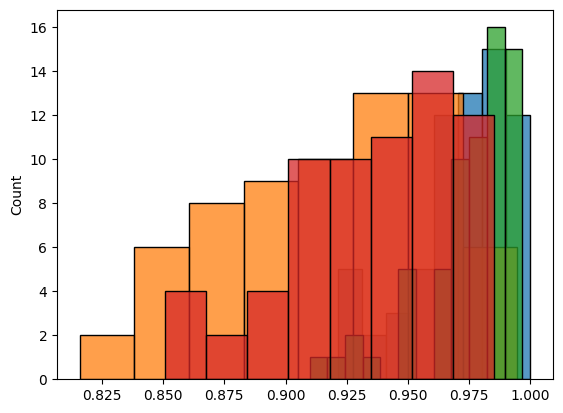

In [31]:
sns.histplot(empirical_accuracies_congruent, label="Empirical Congruent")
sns.histplot(empirical_accuracies_incongruent, label="Empirical Incongruent")
sns.histplot(resimulated_accuracies_congruent, label="Resimulated Congruent")
sns.histplot(resimulated_accuracies_incongruent, label="Resimulated Incongruent")

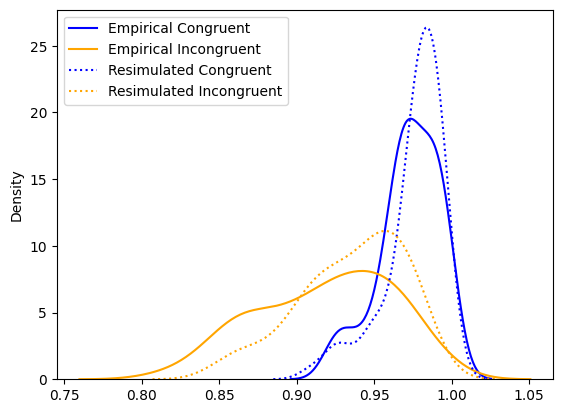

In [37]:
sns.kdeplot(empirical_accuracies_congruent, label="Empirical Congruent", color="blue")
sns.kdeplot(empirical_accuracies_incongruent, label="Empirical Incongruent", color="orange")
sns.kdeplot(resimulated_accuracies_congruent, linestyle=":", label="Resimulated Congruent", color="blue")
sns.kdeplot(resimulated_accuracies_incongruent, linestyle=":", label="Resimulated Incongruent", color="orange")
plt.legend()

In [17]:
data_resimulated

rt  accuracy  conditions  num_obs  num_resim  partricipant
0    0.425380       1.0           0      369          0           985
1    0.583380       1.0           0      369          0           985
2    0.433380       1.0           0      369          0           985
3    0.323380       1.0           0      369          0           985
4    0.348380       1.0           0      369          0           985
..        ...       ...         ...      ...        ...           ...
364  0.538307       1.0           1      369         49           985
365  0.366307       1.0           1      369         49           985
366  0.291307       1.0           1      369         49           985
367  0.301307       0.0           1      369         49           985
368  0.365307       1.0           1      369         49           985

[18450 rows x 6 columns]

## Delta Functions

In [236]:
def delta_functions(data, quantiles = np.arange(0,1, 0.1), 
                  grouping_labels=["participant", "condition_label"],
                  rt_var="rt",
                  congruency_name="condition_label"):
    

    quantile_data = data.groupby(grouping_labels)[rt_var].quantile(quantiles).reset_index()
    
    quantile_data.rename(columns={"level_2": "quantiles"}, inplace=True)

    quantile_data_wide = quantile_data.pivot(index="quantiles", columns=congruency_name, values=rt_var)

    quantile_data_wide["delta"] = quantile_data_wide["incongruent"] - quantile_data_wide["congruent"]

    quantile_data_wide["mean_qu"] = (quantile_data_wide["incongruent"] + quantile_data_wide["congruent"])/2

    return quantile_data_wide
        

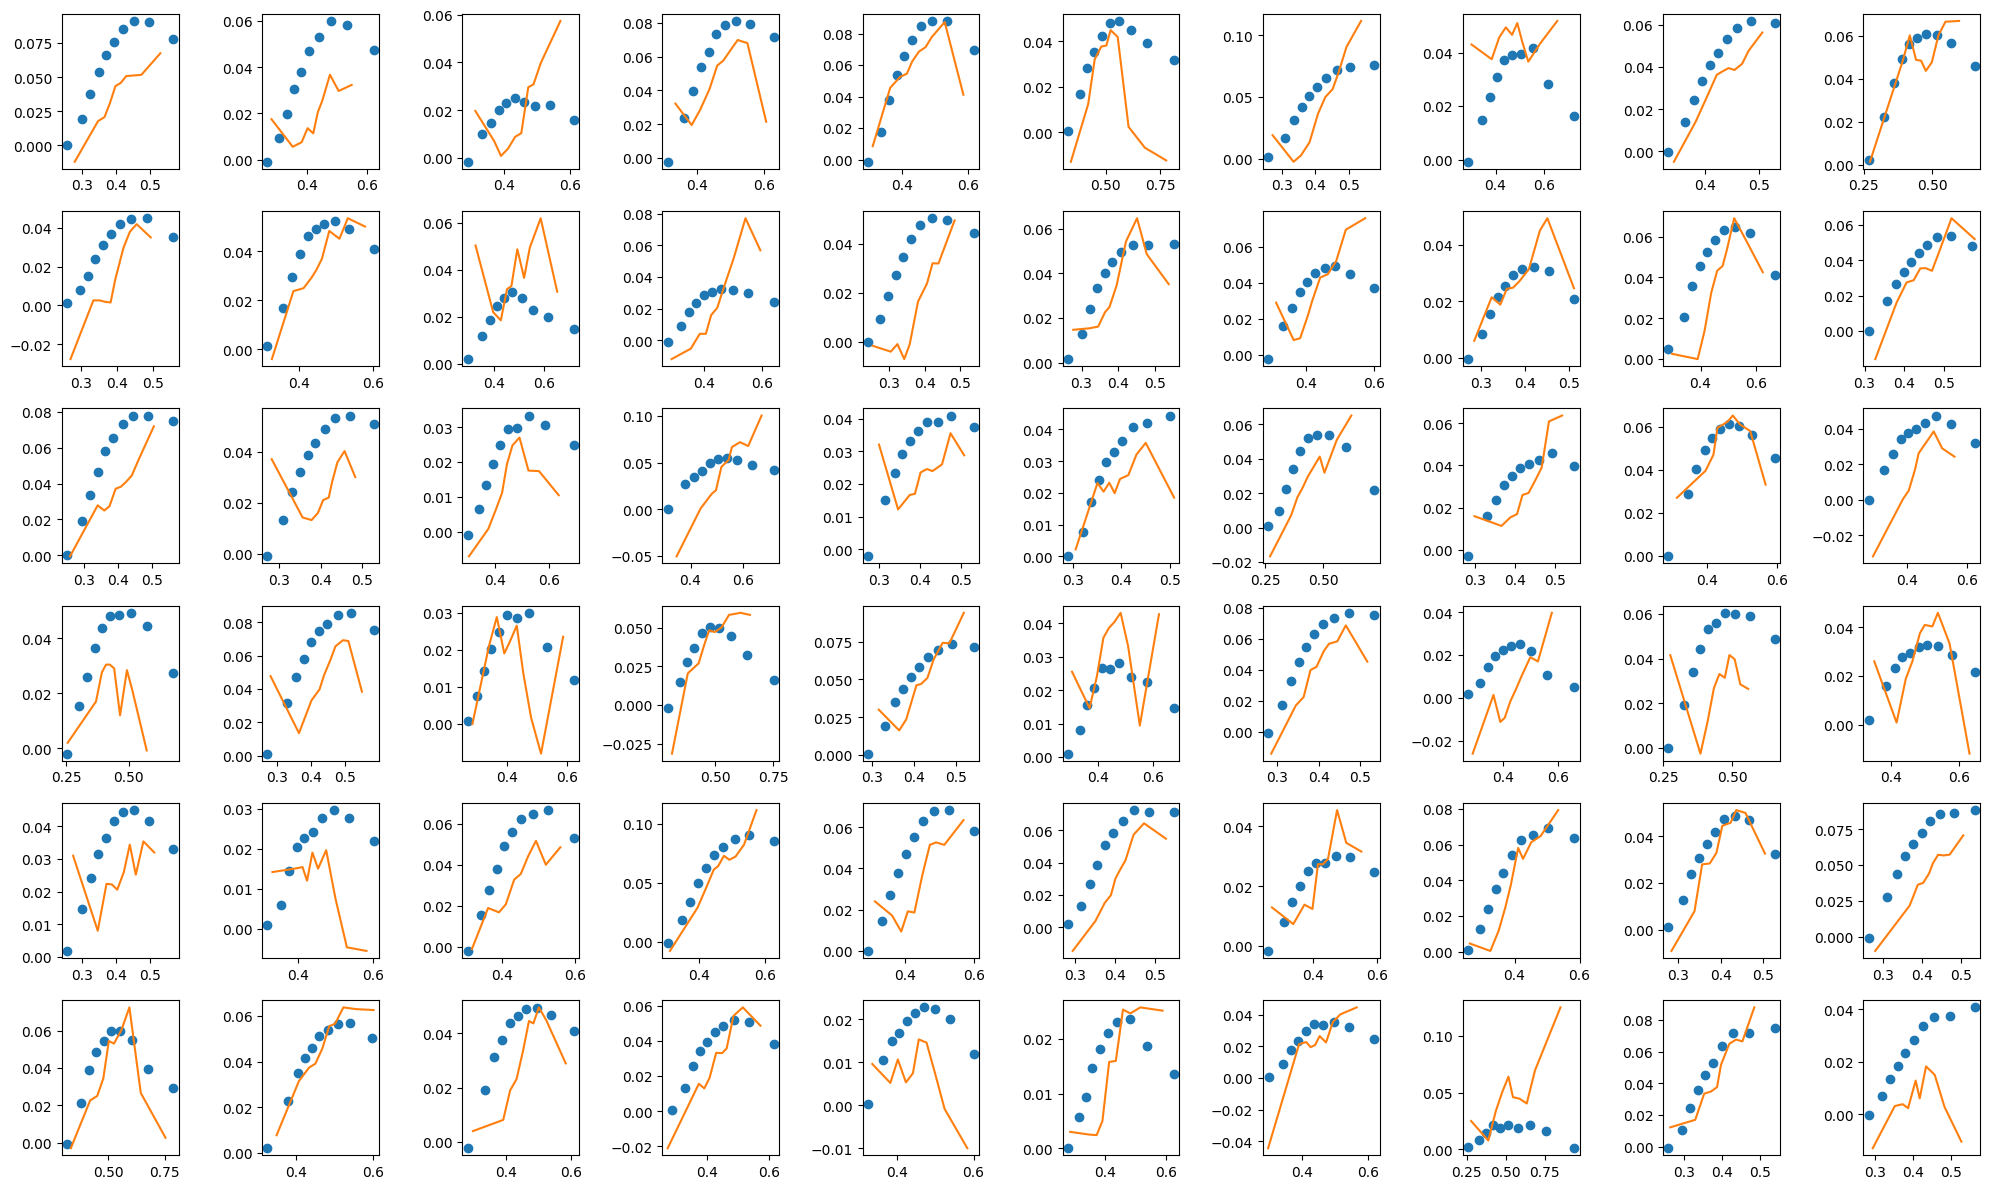

In [243]:
fig, axes = plt.subplots(6, 10, figsize=(20,12))

axes = axes.flatten()

for part, ax in zip(parts, axes):
    
    # filter sample data for given participant and narrow spacing
    part_data_samples = data_complete[data_complete["participant"]==part]

    part_data_samples = part_data_samples[part_data_samples["spacing"] == "narrow"]

    # filter empirical data for given participant and narrow spacing
    part_data = empirical_data[empirical_data["participant"] == part]

    part_data = part_data[part_data["spacing_num"] == 1]

    part_data["condition_label"] = part_data["congruency_num"].map({0.0: "congruent", 1.0: "incongruent"})

    # resimulate data
    data_resimulated = resim_data(part_data_samples, num_obs = part_data.shape[0])

    # exclude non-convergents
    data_resimulated = data_resimulated[data_resimulated["rt"] != -1]

    # recode congruency
    data_resimulated["condition_label"] = data_resimulated["conditions"].map({0.0: "congruent", 1.0: "incongruent"})

    quantiles = np.arange(0,1, 0.1)

    quantile_data_wide_resim = delta_functions(data_resimulated, quantiles = np.arange(0, 1, 0.1))

    quantile_data_wide_empirical = delta_functions(part_data, quantiles = np.arange(0, 1, 0.1))

    ax.plot(quantile_data_wide_resim["mean_qu"] ,quantile_data_wide_resim["delta"] ,"o")
    ax.plot(quantile_data_wide_empirical["mean_qu"] ,quantile_data_wide_empirical["delta"] )

fig.tight_layout()
    

## Reliability 

In [11]:
narrow_data_even=narrow_data.iloc[::2]

narrow_data_odd=narrow_data.iloc[1::2]

post_samples_narrow_even = dmc_helpers.fit_empirical_data(narrow_data_even, approximator)

post_samples_narrow_odd = dmc_helpers.fit_empirical_data(narrow_data_odd, approximator)

In [12]:
post_samples_narrow_odd

A         tau      mu_c          t0           b  participant  \
0    14.995670  113.761131  0.478031  302.205597   81.797813          275   
1     8.403939  172.795868  0.558189  301.788696   84.679077          275   
2    16.400599  106.955467  0.527683  293.235840   94.711449          275   
3    17.804672  152.922073  0.535556  300.511230   85.769684          275   
4    11.168146  136.201660  0.477472  300.207031   77.424850          275   
..         ...         ...       ...         ...         ...          ...   
995  13.814548  167.732376  0.721507  329.239075  109.716263       337788   
996  10.357219  164.029648  0.648569  332.639404   93.060539       337788   
997  14.153481  165.728653  0.632784  339.190857   87.098068       337788   
998  16.715708  185.904221  0.695909  335.215820   98.976463       337788   
999  22.548779  223.497269  0.693990  332.448303   97.256630       337788   

     sampling_time  
0         0.045072  
1         0.045072  
2         0.045072  
3         0.045072  
4         0.045072  
..             ...  
995       0.047275  
996       0.047275  
997       0.047275  
998       0.047275  
999       0.047275  

[67000 rows x 7 columns]

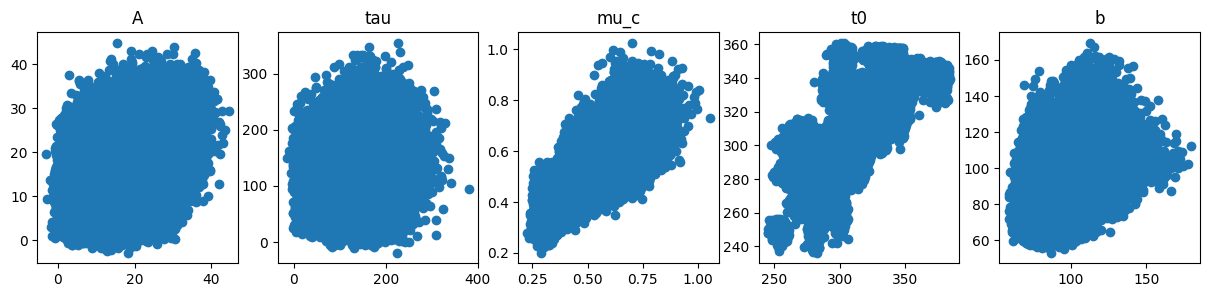

In [14]:
post_median_odd = post_samples_narrow_odd.groupby("participant").median()

post_median_even = post_samples_narrow_even.groupby("participant").median()

param_names =  ["A", "tau", "mu_c", "t0", "b"]

fig, axes = plt.subplots(1,5, figsize=(15,3))
for p, ax in zip(param_names, axes):
    ax.plot(post_samples_narrow_odd[p], post_samples_narrow_even[p], "o")
    ax.plot([])
    
    ax.set_title(p)

## Trial dependency

In [21]:
network_name = "oos500trials_noco"


file_path = '../model_specs/model_specs_' + network_name + '.pickle'

with open(file_path, 'rb') as file:
    model_specs = pickle.load(file)


EOFError: Ran out of input

In [134]:

network_name = "oos500trials_noco"


# file_path = '../model_specs/model_specs_' + network_name + '.pickle'

# with open(file_path, 'wb') as file:
#     pickle.load(file)

model_specs = {'prior_means': np.array([16., 111., 0.5, 322., 75.]),
               'prior_sds': np.array([10., 47., 0.13, 40., 23.]),
               'tmax': 1500,
               'num_obs': 500,
               'network_name': network_name}


simulator = DMC(
    prior_means=model_specs['prior_means'], 
    prior_sds=model_specs['prior_sds'],
    tmax=model_specs['tmax'],
    # contamination_probability=.05,
    num_obs=model_specs['num_obs']
)

adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .sqrt("num_obs")
    .concatenate(["A", "tau", "mu_c", "mu_r", "b"], into="inference_variables")
    .concatenate(["rt", "accuracy", "conditions"], into="summary_variables")
    .standardize(include="inference_variables")
    .rename("num_obs", "inference_conditions")
)
# Create inference net 
inference_net = bf.networks.CouplingFlow(coupling_kwargs=dict(subnet_kwargs=dict(dropout=0.1)))

# inference_net = bf.networks.FlowMatching(subnet_kwargs=dict(dropout=0.1))

summary_net = bf.networks.SetTransformer(summary_dim=32, num_seeds=2, dropout=0.1)

workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    initial_learning_rate=1e-4,
    inference_network=inference_net,
    summary_network=summary_net,
    checkpoint_filepath='../data/training_checkpoints',
    checkpoint_name= "optuna_run1",
    inference_variables=["A", "tau", "mu_c", "mu_r", "b"]
)



Existing checkpoints can _not_ be restored/loaded using this workflow. Upon refitting, the checkpoints will be overwritten. To load the stored approximator from the checkpoint, use approximator = keras.saving.load_model(...)


In [135]:
val_data = simulator.sample(1000)

val_data['t0'] = val_data.pop('mu_r')

In [136]:
approximator = keras.saving.load_model("../data/training_checkpoints/optuna_run1.keras")

samples = approximator.sample(conditions=val_data, num_samples=1000)

bf.diagnostics.metrics.calibration_error(samples, val_data)
pd.DataFrame(bf.diagnostics.metrics.calibration_error(samples, val_data))
bf.diagnostics.metrics.root_mean_squared_error(samples, val_data)

/home/administrator/miniforge3/envs/bf_new/lib/python3.11/site-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


{'values': VariableArray([0.10587023, 0.15850337, 0.1216617 , 0.04651051, 0.0870766 ]),
 'metric_name': 'NRMSE',
 'variable_names': ['A', 'tau', 'mu_c', 't0', 'b']}

In [155]:

def subset_data(data, num_obs):

    data = data.copy()

    keys = ['rt', 'accuracy', 'conditions']

    max_obs = data['rt'].shape[1]

    random_idx = np.random.choice(np.arange(0, max_obs), size=num_obs, replace=False)

    for k in keys:
        # print(f'{data[k].shape}')
        data[k] = data[k][:, random_idx, :]
        # print(f'{data[k].shape}')


    data['num_obs'] = np.array([num_obs]*1000).reshape(1000,1)

    return data

In [158]:
val_data = simulator.sample(1000)

val_data['t0'] = val_data.pop('mu_r')

val_data['rt'].shape[1]


500

In [ ]:
# subset_data(val_data, 100)

# num_obs = 5

# keys = ['rt', 'accuracy', 'conditions']

# max_obs = val_data['rt'].shape[1]

# random_idx = np.random.choice(np.arange(0, max_obs), num_obs, replace=False)

# for k in keys:
#     # print(f'{data[k].shape}')
#     val_data[k] = val_data[k][:, random_idx, :]
#     # print(f'{data[k].shape}')


# val_data['num_obs'] = np.array([num_obs]*1000).reshape(1000,1)

# val_data['rt'].shape

(1000, 5, 1)

In [154]:
val_data['rt'].shape

(1000, 5, 1)

In [171]:
import pandas as pd

list_metrics = []

step_size = 50

num_max_obs = 500


for n_obs in np.arange(50, num_max_obs, step_size):
    
    print(f'num_obs: {n_obs}')
    # simulator.num_obs = n_obs

    data_subset = subset_data(val_data, num_obs=n_obs)

    samples = approximator.sample(conditions=data_subset, num_samples=1000)
    
    # metrics_table=workflow.compute_default_diagnostics(test_data=data_subset)
    results_single = pd.concat([pd.DataFrame(bf.diagnostics.metrics.calibration_error(samples, data_subset)),
                                 pd.DataFrame(bf.diagnostics.metrics.posterior_contraction(samples, data_subset)),
                                 pd.DataFrame(bf.diagnostics.metrics.root_mean_squared_error(samples, data_subset))])
    
    
    results_single["num_obs"] = n_obs
    
    list_metrics.append(results_single)
    
data_set_metrics = pd.concat(list_metrics)

data_set_metrics

num_obs: 50
num_obs: 100
num_obs: 150
num_obs: 200
num_obs: 250
num_obs: 300
num_obs: 350
num_obs: 400
num_obs: 450


values        metric_name variable_names  num_obs
0   0.222895  Calibration Error              A       50
1   0.168395  Calibration Error            tau       50
2   0.389000  Calibration Error           mu_c       50
3   0.484500  Calibration Error             t0       50
4   0.393000  Calibration Error              b       50
..       ...                ...            ...      ...
0   0.098065              NRMSE              A      450
1   0.148587              NRMSE            tau      450
2   0.118767              NRMSE           mu_c      450
3   0.040347              NRMSE             t0      450
4   0.077223              NRMSE              b      450

[135 rows x 4 columns]

In [ ]:

# sns.lineplot(data_set_metrics[data_set_metrics["variable_names"] == 'A'], x="num_obs", y="values", hue="metric_name", ax=ax, palette="colorblind")

<Axes: title={'center': '$A$'}, xlabel='num_obs', ylabel='values'>

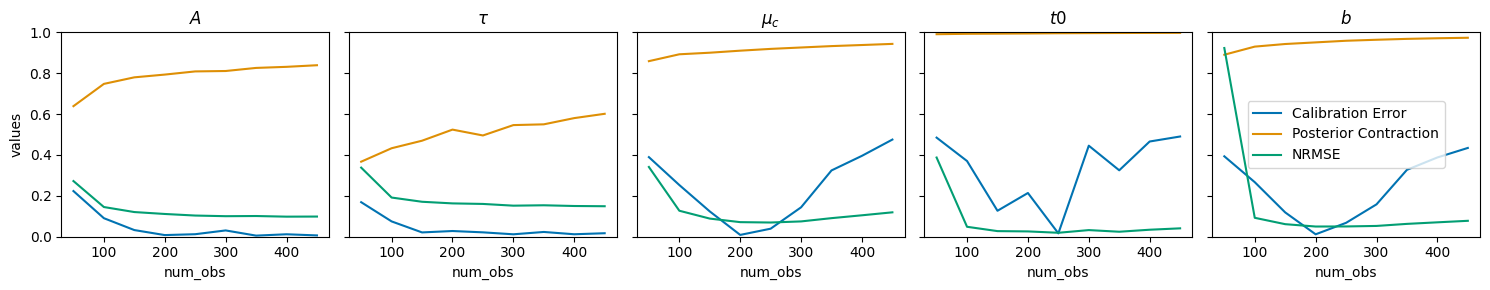

In [178]:
import matplotlib.pyplot as plt
import seaborn as sns

param_names =  ["A", "tau", "mu_c", "t0", "b"]

fig, axes = plt.subplots(1,5,sharey=True, figsize=(15,3))

for p, ax in zip(param_names, axes):
    
    suff = "$\\" if p in ["tau", "mu_c", "mu_r"] else "$"

    label = suff + p + "$"
    
    sns.lineplot(data_set_metrics[data_set_metrics["variable_names"] == p], x="num_obs", y="values", hue="metric_name", ax=ax, palette="colorblind")
    ax.set_title(label)
    ax.legend(title="")
    if p != "b":
        ax.get_legend().remove()

    plt.ylim(0, 1)

fig.tight_layout()

In [117]:
data_set_metrics.reset_index(inplace=True, names="metric")
data_set_metrics


ValueError: cannot insert metric, already exists

In [118]:
data_metrics_long =data_set_metrics.melt(id_vars=["metric", "num_obs"], value_vars=["A", "tau", "mu_c", "mu_r", "b"], var_name="parameter", value_name="score")

AttributeError: 'Axes' object has no attribute 'set_'

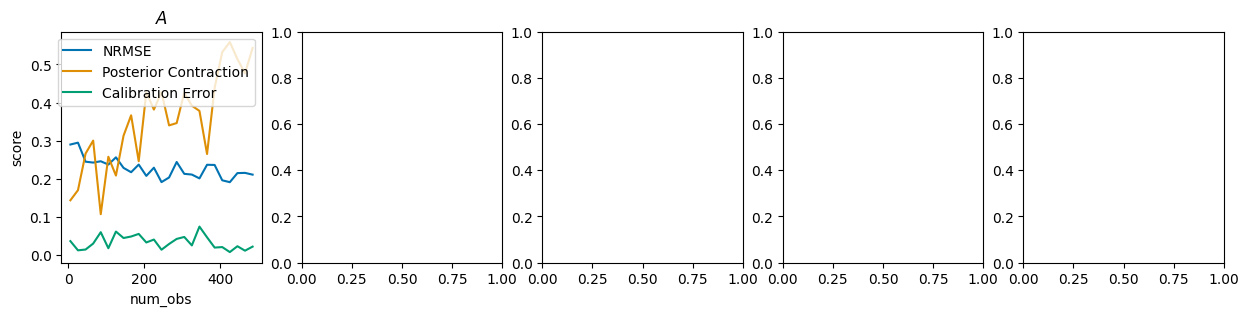

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

param_names =  ["A", "tau", "mu_c", "mu_r", "b"]

fig, axes = plt.subplots(1,5, figsize=(15,3))

for p, ax in zip(param_names, axes):
    
    suff = "$\\" if p in ["tau", "mu_c", "mu_r"] else "$"

    label = suff + p + "$"
    
    sns.lineplot(data_metrics_long[data_metrics_long["parameter"] == p], x="num_obs", y="score", hue="metric", ax=ax, palette="colorblind")
    ax.set_title(label)
    ax.legend(title="")
    ax.set_
    if p != "b":
        ax.get_legend().remove()

fig.tight_layout()
# sns.lineplot(data_metrics_long, x="num_obs", y ="score", col="parameter")

In [42]:
metrics_table["n_obs"] = 10

metrics_table

A       tau      mu_c      mu_r         b  n_obs
NRMSE                  0.282219  0.284907  0.162782  0.110885  0.136611     10
Posterior Contraction  0.198050  0.025385  0.719526  0.874438  0.799351     10
Calibration Error      0.011974  0.013421  0.116974  0.102763  0.081447     10